# Estadísticas No Paramétricas y Pruebas Robustas

## Ejercicios práctico para aplicar los conceptos aprendidos.

#### Preparación de dataset con características no normales

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Generar dataset de clientes con distribuciones no normales
np.random.seed(42)
n_clientes = 300

df = pd.DataFrame({
    'cliente_id': range(1, n_clientes + 1),
    'segmento': np.random.choice(['Bronce', 'Plata', 'Oro'], n_clientes, p=[0.5, 0.3, 0.2]),
    'gasto_total': np.random.exponential(200, n_clientes),  # Distribución exponencial
    'frecuencia_visitas': np.random.poisson(3, n_clientes),  # Conteos
    'satisfaccion': np.random.beta(2, 1, n_clientes) * 10,  # Distribución beta (0-10)
    'antiguedad_dias': np.random.exponential(365, n_clientes).astype(int)
})

print("DATASET PARA ANÁLISIS NO PARAMÉTRICO")
print("=" * 40)
print(f"Clientes analizados: {len(df)}")
print("Distribuciones:")
print("- Gasto total: Exponencial (sesgada derecha)")
print("- Frecuencia visitas: Poisson (discreta)")
print("- Satisfacción: Beta (acotada 0-10)")
print("- Antigüedad: Exponencial")

# Verificar no normalidad
print("TEST DE NORMALIDAD (Shapiro-Wilk):")
for col in ['gasto_total', 'frecuencia_visitas', 'satisfaccion', 'antiguedad_dias']:
    stat, p = stats.shapiro(df[col])
    normal = "SÍ" if p > 0.05 else "NO"
    print(f"{col:20} | Normal: {normal} (p={p:.4f})")

DATASET PARA ANÁLISIS NO PARAMÉTRICO
Clientes analizados: 300
Distribuciones:
- Gasto total: Exponencial (sesgada derecha)
- Frecuencia visitas: Poisson (discreta)
- Satisfacción: Beta (acotada 0-10)
- Antigüedad: Exponencial
TEST DE NORMALIDAD (Shapiro-Wilk):
gasto_total          | Normal: NO (p=0.0000)
frecuencia_visitas   | Normal: NO (p=0.0000)
satisfaccion         | Normal: NO (p=0.0000)
antiguedad_dias      | Normal: NO (p=0.0000)


#### Comparaciones no paramétricas entre segmentos

In [20]:
# Preparar datos por segmento
segmentos = {}
for seg in ['Bronce', 'Plata', 'Oro']:
    segmentos[seg] = df[df['segmento'] == seg]['gasto_total'].values

print("COMPARACIÓN DE GASTO TOTAL ENTRE SEGMENTOS")
print("=" * 50)

# Estadísticas descriptivas robustas
for seg, datos in segmentos.items():
    mediana = np.median(datos)
    q25, q75 = np.percentile(datos, [25, 75])
    iqr = q75 - q25
    print(f"{seg:6} | Mediana: ${mediana:7.0f} | IQR: ${iqr:6.0f} | n={len(datos)}")

# Prueba Kruskal-Wallis (ANOVA no paramétrico)
h_stat, p_kw = stats.kruskal(*segmentos.values())

print("PRUEBA KRUSKAL-WALLIS:")
print(f"Estadístico H: {h_stat:.3f}")
print(f"Valor p: {p_kw:.4f}")
print(f"Diferencias significativas: {'SÍ' if p_kw < 0.05 else 'NO'}")

# Comparaciones pareadas con Mann-Whitney
print("COMPARACIONES PAREADAS (Mann-Whitney):")
from itertools import combinations
segmento_nombres = list(segmentos.keys())

for seg1, seg2 in combinations(segmento_nombres, 2):
    u_stat, p_mw = stats.mannwhitneyu(segmentos[seg1], segmentos[seg2], alternative='two-sided')
    significativo = "SÍ" if p_mw < 0.05 else "NO"
    print(f"{seg1} vs {seg2}: U={u_stat:.1f}, p={p_mw:.4f} ({significativo})")


COMPARACIÓN DE GASTO TOTAL ENTRE SEGMENTOS
Bronce | Mediana: $    160 | IQR: $   269 | n=144
Plata  | Mediana: $    159 | IQR: $   254 | n=93
Oro    | Mediana: $    119 | IQR: $   185 | n=63
PRUEBA KRUSKAL-WALLIS:
Estadístico H: 3.896
Valor p: 0.1426
Diferencias significativas: NO
COMPARACIONES PAREADAS (Mann-Whitney):
Bronce vs Plata: U=6866.0, p=0.7422 (NO)
Bronce vs Oro: U=5318.0, p=0.0487 (SÍ)
Plata vs Oro: U=3336.0, p=0.1425 (NO)


#### Correlaciones no paramétricas

In [21]:
# Análisis de correlaciones no paramétricas
variables_numericas = ['gasto_total', 'frecuencia_visitas', 'satisfaccion', 'antiguedad_dias']

print("ANÁLISIS DE CORRELACIONES")
print("=" * 30)

# Matriz de correlaciones: Pearson vs Spearman
corr_pearson = df[variables_numericas].corr(method='pearson')
corr_spearman = df[variables_numericas].corr(method='spearman')

print("CORRELACIÓN PEARSON (paramétrica):") 
for i, var1 in enumerate(variables_numericas): 
    for j, var2 in enumerate(variables_numericas): 
        if i < j:
            corr_p = corr_pearson.loc[var1, var2] 
            print(f"{var1[:8]:8} ↔ {var2[:8]:8} | Pearson: {corr_p:+.3f}")

print("\nCORRELACIÓN SPEARMAN (no paramétrica):") 
for i, var1 in enumerate(variables_numericas): 
    for j, var2 in enumerate(variables_numericas): 
        if i < j:
            corr_s = corr_spearman.loc[var1, var2] 
            print(f"{var1[:8]:8} ↔ {var2[:8]:8} | Spearman: {corr_s:+.3f}")

# Identificar diferencias importantes
diferencias = (corr_spearman - corr_pearson).abs() 
max_diff_idx = diferencias.where(np.triu(np.ones_like(diferencias), k=1).astype(bool)).stack().idxmax() 
max_diff = diferencias.stack().max()

print(f"\nMayor diferencia: {max_diff_idx[0]} ↔ {max_diff_idx[1]} = {max_diff:.3f}")




ANÁLISIS DE CORRELACIONES
CORRELACIÓN PEARSON (paramétrica):
gasto_to ↔ frecuenc | Pearson: +0.016
gasto_to ↔ satisfac | Pearson: -0.001
gasto_to ↔ antigued | Pearson: +0.056
frecuenc ↔ satisfac | Pearson: -0.064
frecuenc ↔ antigued | Pearson: -0.030
satisfac ↔ antigued | Pearson: -0.003

CORRELACIÓN SPEARMAN (no paramétrica):
gasto_to ↔ frecuenc | Spearman: +0.033
gasto_to ↔ satisfac | Spearman: +0.037
gasto_to ↔ antigued | Spearman: +0.043
frecuenc ↔ satisfac | Spearman: -0.084
frecuenc ↔ antigued | Spearman: +0.006
satisfac ↔ antigued | Spearman: -0.021

Mayor diferencia: gasto_total ↔ satisfaccion = 0.038


#### Bootstrap para estimación robusta

In [22]:
# **Bootstrap para estimación robusta**:

# Función de bootstrap para intervalos de confianza
def bootstrap_ci(data, func=np.mean, n_bootstrap=1000, ci_level=0.95):
    """Calcula intervalo de confianza bootstrap"""
    bootstrap_vals = []
    n = len(data)
    for _ in range(n_bootstrap):
        # Resample indices to maintain pairing for multivariate data
        indices = np.random.choice(n, size=n, replace=True)
        if isinstance(data[0], (list, tuple)):
            sample = [data[i] for i in indices]
        else:
            sample = np.array(data)[indices]
        bootstrap_vals.append(func(sample))
    
    alpha = (1 - ci_level) / 2
    lower = np.percentile(bootstrap_vals, alpha * 100)
    upper = np.percentile(bootstrap_vals, (1 - alpha) * 100)
    
    return np.mean(bootstrap_vals), lower, upper

print("ESTIMACIÓN ROBUSTA CON BOOTSTRAP")
print("=" * 40)

# Bootstrap para gasto total por segmento
for segmento, datos in segmentos.items():
    media_boot, ci_lower, ci_upper = bootstrap_ci(datos, func=np.median, n_bootstrap=1000)
    print(f"{segmento:6} | Mediana Bootstrap: ${media_boot:7.0f} (IC 95%: ${ci_lower:7.0f}, ${ci_upper:7.0f})")

gasto = df['gasto_total'].values
satisfaccion = df['satisfaccion'].values

def corr_func(data):
    x, y = zip(*data)
    return stats.spearmanr(x, y)[0]

corr_boot, corr_lower, corr_upper = bootstrap_ci(list(zip(gasto, satisfaccion)), func=corr_func, n_bootstrap=1000)

print(f"\nCorrelación Gasto-Satisfacción:")
print(f"Bootstrap: {corr_boot:.3f} (IC 95%: {corr_lower:.3f}, {corr_upper:.3f})")


ESTIMACIÓN ROBUSTA CON BOOTSTRAP
Bronce | Mediana Bootstrap: $    158 (IC 95%: $    131, $    195)
Plata  | Mediana Bootstrap: $    159 (IC 95%: $    109, $    201)
Oro    | Mediana Bootstrap: $    118 (IC 95%: $     78, $    161)

Correlación Gasto-Satisfacción:
Bootstrap: 0.036 (IC 95%: -0.083, 0.143)


#### Visualización comparativa de métodos

C:\Users\marely\AppData\Local\Temp\ipykernel_27716\1898389284.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([segmentos[seg] for seg in segmentos.keys()], labels=segmentos.keys(), patch_artist=True)



Análisis no paramétrico guardado como 'analisis_no_parametrico_completo.png'
RESUMEN EJECUTIVO - ANÁLISIS ROBUSTO
Diferencias entre segmentos: No significativas
Correlación gasto-satisfacción: 0.036 (robusta)
IC bootstrap correlación: (-0.083, 0.143)
Método recomendado: Estadística no paramétrica (datos no normales)


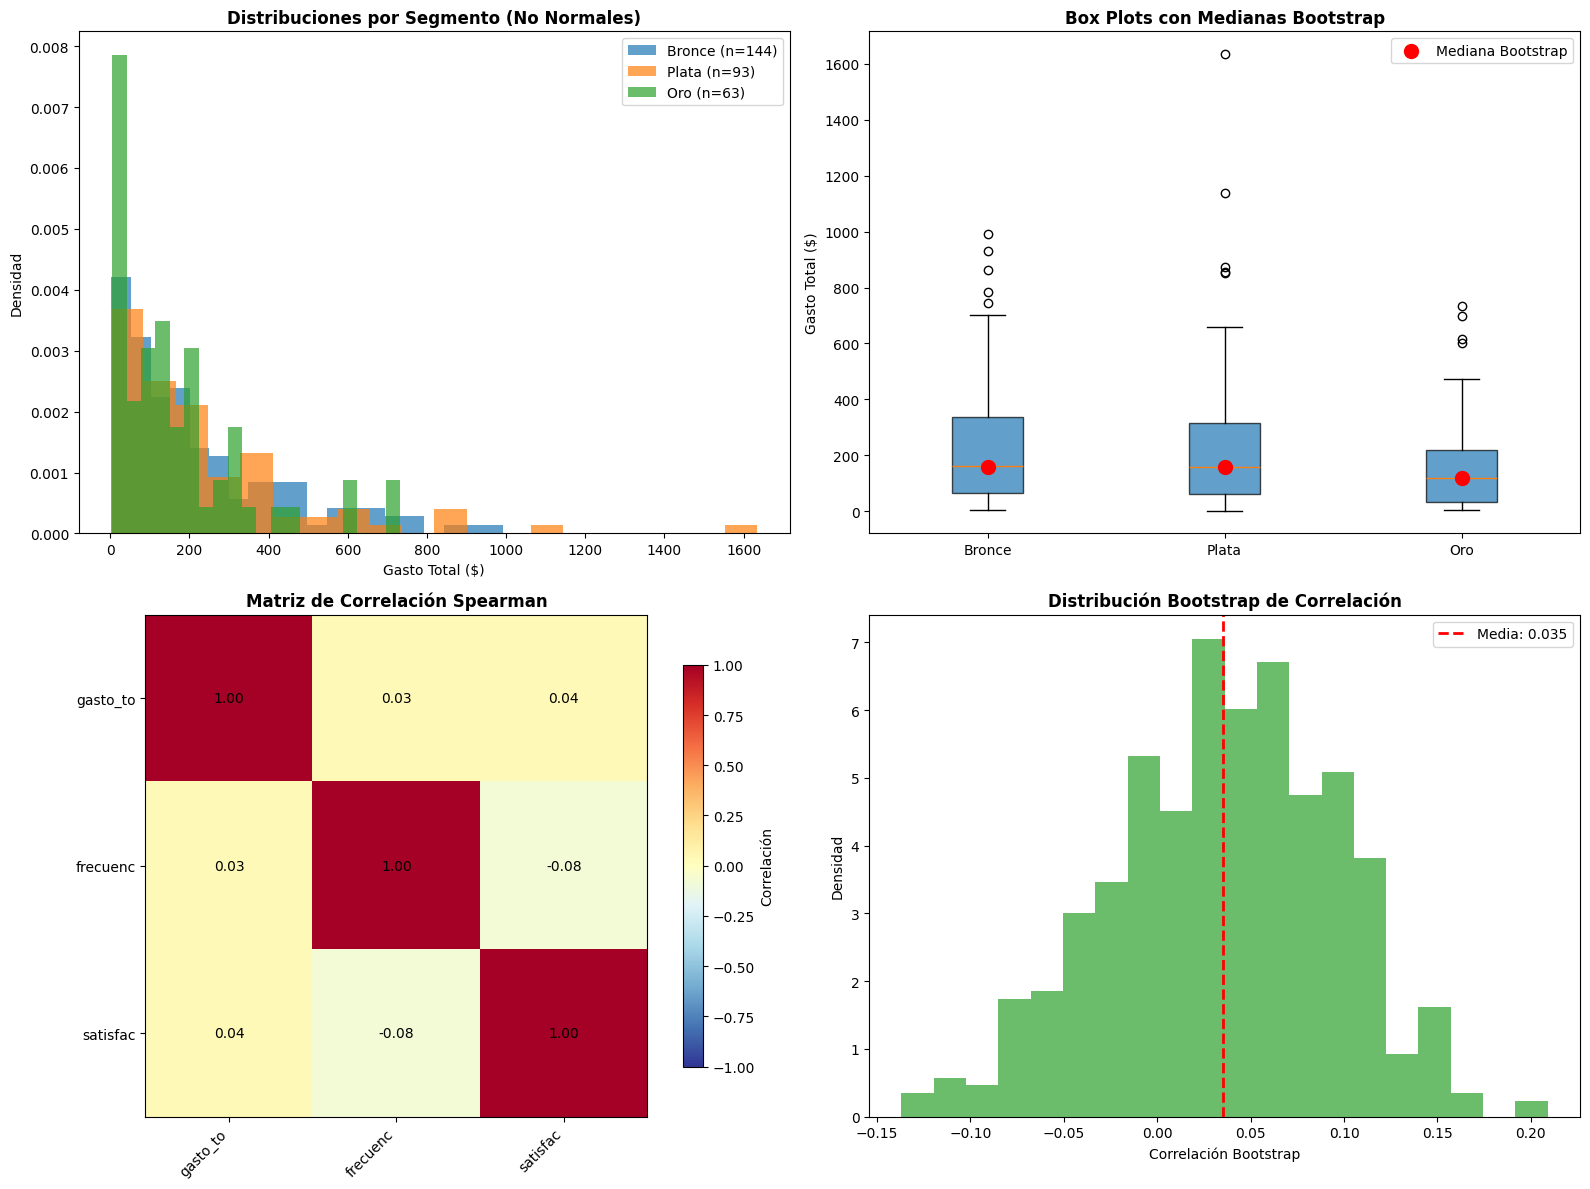

In [23]:
# Crear visualización comparativa
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de distribuciones por segmento
for i, (seg, datos) in enumerate(segmentos.items()):
    ax1.hist(datos, bins=20, alpha=0.7, label=f'{seg} (n={len(datos)})', density=True)
ax1.set_xlabel('Gasto Total ($)')
ax1.set_ylabel('Densidad')
ax1.set_title('Distribuciones por Segmento (No Normales)', fontweight='bold')
ax1.legend()

# 2. Box plots con puntos de mediana bootstrap
bp = ax2.boxplot([segmentos[seg] for seg in segmentos.keys()], labels=segmentos.keys(), patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#1f77b4')
    patch.set_alpha(0.7)

# Añadir medianas bootstrap como puntos
for i, (seg, datos) in enumerate(segmentos.items()):
    mediana_boot, _, _ = bootstrap_ci(datos, func=np.median)
    ax2.scatter(i+1, mediana_boot, color='red', s=100, zorder=3, label='Mediana Bootstrap' if i == 0 else "")

ax2.set_ylabel('Gasto Total ($)')
ax2.set_title('Box Plots con Medianas Bootstrap', fontweight='bold')
ax2.legend()

# 3. Comparación de correlaciones
variables_plot = ['gasto_total', 'frecuencia_visitas', 'satisfaccion']
corr_matrix = df[variables_plot].corr(method='spearman')

im = ax3.imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax3.set_xticks(range(len(variables_plot)))
ax3.set_yticks(range(len(variables_plot)))
ax3.set_xticklabels([v[:8] for v in variables_plot], rotation=45, ha='right')
ax3.set_yticklabels([v[:8] for v in variables_plot])
ax3.set_title('Matriz de Correlación Spearman', fontweight='bold')

# Añadir valores
for i in range(len(variables_plot)):
    for j in range(len(variables_plot)):
        text = ax3.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

# Barra de color
cbar = fig.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Correlación')

# 4. Distribución bootstrap de correlación
# Simular bootstrap para visualización
bootstrap_corrs = []
for _ in range(500):  # Menos iteraciones para visualización
    sample_idx = np.random.choice(len(df), size=len(df), replace=True)
    sample_data = df.iloc[sample_idx]
    corr = stats.spearmanr(sample_data['gasto_total'], sample_data['satisfaccion'])[0]
    bootstrap_corrs.append(corr)

ax4.hist(bootstrap_corrs, bins=20, alpha=0.7, color='#2ca02c', density=True)
ax4.axvline(np.mean(bootstrap_corrs), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(bootstrap_corrs):.3f}')
ax4.set_xlabel('Correlación Bootstrap')
ax4.set_ylabel('Densidad')
ax4.set_title('Distribución Bootstrap de Correlación', fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('analisis_no_parametrico_completo.png', dpi=300, bbox_inches='tight')
print("\nAnálisis no paramétrico guardado como 'analisis_no_parametrico_completo.png'")

# Resumen ejecutivo
print("RESUMEN EJECUTIVO - ANÁLISIS ROBUSTO")
print("=" * 45)
print(f"Diferencias entre segmentos: {'Confirmadas' if p_kw < 0.05 else 'No significativas'}")
print(f"Correlación gasto-satisfacción: {corr_boot:.3f} (robusta)") 
print(f"IC bootstrap correlación: ({corr_lower:.3f}, {corr_upper:.3f})") 
print("Método recomendado: Estadística no paramétrica (datos no normales)")

